In [1]:
# Cell 1: imports + device
import re
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import random
import os
import json
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
def load_and_clean_text(file_path):
    """Load file, lowercase, remove URLs, keep alnum, space and full-stop '.'."""
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read().lower()
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    # ensure spaces around periods to keep them separate tokens if you want
    text = re.sub(r'(\w)(\.)', r'\1 .', text)
    # keep only alphanumeric, space and dot
    text = re.sub(r'[^a-z0-9 \.]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    return words


In [3]:

def build_vocab(words, reserved_tokens=['<PAD>','<UNK>','<EOS>']):
    """Create token->idx and idx->token dicts and a frequency counter."""
    counter = Counter(words)
    # sort tokens by frequency (desc) then lexicographically
    tokens_sorted = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    stoi = {}
    # reserved tokens first
    idx = 0
    for t in reserved_tokens:
        stoi[t] = idx; idx += 1
    for w, _ in tokens_sorted:
        if w not in stoi:
            stoi[w] = idx; idx += 1
    itos = {i: w for w, i in stoi.items()}
    vocab_size = len(stoi)
    return stoi, itos, vocab_size, counter

In [4]:

def print_vocab_stats(counter, stoi, top_k=10):
    """Print vocab size and most/least frequent tokens for report."""
    vocab_size = len(stoi)
    print(f"Vocabulary size (including reserved tokens): {vocab_size}")
    most = counter.most_common(top_k)
    print(f"\nTop {top_k} most frequent tokens:")
    for token, freq in most:
        print(f"{token} : {freq}")
    # least frequent - show tokens with lowest frequency (including many with freq 1)
    least = sorted(counter.items(), key=lambda x: (x[1], x[0]))[:top_k]
    print(f"\nTop {top_k} least frequent tokens:")
    for token, freq in least:
        print(f"{token} : {freq}")


In [5]:
!wget -q https://www.gutenberg.org/files/1661/1661-0.txt -O holmes.txt

words = load_and_clean_text('holmes.txt')

print(f"Loaded words: {len(words)} (tokens), sample: {words[:20]}")

stoi, itos, vocab_size, counter = build_vocab(words)
print_vocab_stats(counter, stoi, top_k=10)


Loaded words: 115481 (tokens), sample: ['the', 'project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle', 'this', 'ebook', 'is', 'for', 'the', 'use']
Vocabulary size (including reserved tokens): 8171

Top 10 most frequent tokens:
. : 6333
the : 5822
and : 3085
i : 3038
to : 2826
of : 2781
a : 2697
in : 1826
that : 1767
it : 1749

Top 10 least frequent tokens:
.b : 1
10th : 1
12 : 1
12th : 1
140 : 1
150 : 1
1500 : 1
1661 : 1
16a : 1
17 : 1


In [6]:
def create_dataset(words, stoi, context_length, show_first_n=20):
    X, Y = [], []
    for i in range(len(words) - context_length):
        context = words[i:i+context_length]
        target = words[i+context_length]
        X.append([stoi.get(w, stoi['<UNK>']) for w in context])
        Y.append(stoi.get(target, stoi['<UNK>']))
        if i < show_first_n:
            print(f"{' '.join(context)} ---> {target}")
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(f"\nDataset created with shapes: X: {X.shape}, Y: {Y.shape}")
    return X, Y

In [7]:
# create dataset and split
context_length = 5
X, Y = create_dataset(words, stoi, context_length)


the project gutenberg ebook of ---> the
project gutenberg ebook of the ---> adventures
gutenberg ebook of the adventures ---> of
ebook of the adventures of ---> sherlock
of the adventures of sherlock ---> holmes
the adventures of sherlock holmes ---> by
adventures of sherlock holmes by ---> arthur
of sherlock holmes by arthur ---> conan
sherlock holmes by arthur conan ---> doyle
holmes by arthur conan doyle ---> this
by arthur conan doyle this ---> ebook
arthur conan doyle this ebook ---> is
conan doyle this ebook is ---> for
doyle this ebook is for ---> the
this ebook is for the ---> use
ebook is for the use ---> of
is for the use of ---> anyone
for the use of anyone ---> anywhere
the use of anyone anywhere ---> in
use of anyone anywhere in ---> the

Dataset created with shapes: X: torch.Size([115476, 5]), Y: torch.Size([115476])


In [8]:
class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, emb_dim, context_length, hidden1, hidden2=None,
                 activation='relu', dropout=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        activation_layer = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'gelu': nn.GELU(),
            'leakyrelu': nn.LeakyReLU()
        }.get(activation.lower(), nn.ReLU())
        layers = [nn.Flatten(),
                  nn.Linear(context_length * emb_dim, hidden1),
                  activation_layer,
                  nn.Dropout(dropout)]
        if hidden2:
            layers += [nn.Linear(hidden1, hidden2),
                       activation_layer,
                       nn.Dropout(dropout),
                       nn.Linear(hidden2, vocab_size)]
        else:
            layers += [nn.Linear(hidden1, vocab_size)]
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x = self.emb(x)
        return self.mlp(x)

    def get_embeddings(self):
        return self.emb.weight.detach().cpu().numpy()

def build_model_from_config(config):
    return NextWordMLP(
        vocab_size=config['vocab_size'],
        emb_dim=config['emb_dim'],
        context_length=config['context_length'],
        hidden1=config['hidden1'],
        hidden2=config.get('hidden2', None),
        activation=config.get('activation', 'relu'),
        dropout=config.get('dropout', 0.2)
    ).to(device)


In [9]:
def train_model(model, X, Y, val_split=0.1, epochs=50, batch_size=2048, lr=3e-3,
                model_ckpt_path='best_model.pt', print_every=5):
    import torch, os
    import torch.nn as nn
    import torch.optim as optim

    # shuffle and split
    N = X.size(0)
    perm = torch.randperm(N)
    X = X[perm]; Y = Y[perm]
    val_n = int(N * val_split)
    if val_n == 0:
        val_n = max(1, int(N * 0.05))
    train_X = X[:-val_n]; train_Y = Y[:-val_n]
    val_X = X[-val_n:]; val_Y = Y[-val_n:]

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        perm_train = torch.randperm(train_X.size(0))

        for i in range(0, train_X.size(0), batch_size):
            idx = perm_train[i:i+batch_size]
            xb = train_X[idx].to(device)
            yb = train_Y[idx].to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)

        avg_train_loss = total_loss / train_X.size(0)

        # validation
        model.eval()
        with torch.no_grad():
            val_logits = model(val_X.to(device))
            val_loss = loss_fn(val_logits, val_Y.to(device)).item()
            preds = torch.argmax(val_logits, dim=1).cpu()
            val_acc = (preds == val_Y.cpu()).float().mean().item()

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Logging
        if epoch % print_every == 0 or epoch == 1:
            print(f"Epoch {epoch}/{epochs} - train_loss: {avg_train_loss:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

        # Save best checkpoint
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            torch.save({'model_state': model.state_dict()}, model_ckpt_path)

    # Load best model after full training
    if os.path.exists(model_ckpt_path):
        ckpt = torch.load(model_ckpt_path, map_location=device)
        model.load_state_dict(ckpt['model_state'])

    return history


In [10]:
# Embedding visualization helpers
def visualize_embeddings_tsne(model, itos, emb_dim, n_words=200, title="Embeddings TSNE", selected_words=None):
    embeddings = model.get_embeddings()
    # skip reserved tokens (we put <PAD>,<UNK>,<EOS> at 0,1,2)
    start_idx = 3
    if emb_dim != 2:
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
        # choose indices to visualize
        if selected_words:
            indices = [stoi.get(w, stoi['<UNK>']) for w in selected_words]
            vectors = embeddings[indices]
            labels = [itos[i] for i in indices]
        else:
            indices = list(range(start_idx, min(start_idx + n_words, embeddings.shape[0])))
            vectors = embeddings[indices]
            labels = [itos[i] for i in indices]
        emb_2d = tsne.fit_transform(vectors)
    else:
        indices = list(range(start_idx, min(start_idx + n_words, embeddings.shape[0])))
        emb_2d = embeddings[indices]
        labels = [itos[i] for i in indices]

    plt.figure(figsize=(12,10))
    plt.scatter(emb_2d[:,0], emb_2d[:,1], s=14, alpha=0.7)
    for i,(x,y) in enumerate(emb_2d):
        plt.text(x+0.3, y+0.3, labels[i], fontsize=8)
    plt.title(title)
    plt.show()


In [11]:
# Generation helper (temperature + top-k optional)
def sample_from_logits(logits, temperature=1.0, top_k=None):
    logits = logits.cpu().numpy().astype(np.float64)
    logits = logits / (temperature + 1e-12)
    probs = np.exp(logits - np.max(logits))
    probs = probs / probs.sum()
    if top_k is not None:
        top_k = max(1, top_k)
        top_indices = probs.argsort()[-top_k:][::-1]
        top_probs = probs[top_indices]
        top_probs = top_probs / top_probs.sum()
        choice = np.random.choice(top_indices, p=top_probs)
        return int(choice)
    else:
        return int(np.random.choice(len(probs), p=probs))

def generate_text(model, stoi, itos, seed_text, length=30, context_length=5, temperature=1.0, top_k=None):
    model.eval()
    words_in = seed_text.lower().split()
    context = ([stoi['<PAD>']] * max(0, context_length - len(words_in)) +
               [stoi.get(w, stoi['<UNK>']) for w in words_in])[-context_length:]
    generated = words_in.copy()
    for _ in range(length):
        x = torch.tensor([context], dtype=torch.long).to(device)
        with torch.no_grad():
            logits = model(x).squeeze(0)
        next_idx = sample_from_logits(logits, temperature=temperature, top_k=top_k)
        next_word = itos.get(next_idx, '<UNK>')
        generated.append(next_word)
        context = context[1:] + [next_idx]
    return ' '.join(generated)


In [12]:
def save_artifacts_full(model, stoi, itos, config, base_name="model_bundle"):
    # Save state dict separately + small json for vocab/config
    model_state_path = f"{base_name}_state.pt"
    torch.save({'model_state': model.state_dict()}, model_state_path)
    with open(f"{base_name}_vocab.json", 'w', encoding='utf-8') as f:
        json.dump(stoi, f, ensure_ascii=False)
    with open(f"{base_name}_config.json", 'w', encoding='utf-8') as f:
        json.dump(config, f)
    print(f"Saved: {model_state_path}, {base_name}_vocab.json, {base_name}_config.json")


In [13]:
# create dataset and split
context_length = 5
X, Y = create_dataset(words, stoi, context_length)

the project gutenberg ebook of ---> the
project gutenberg ebook of the ---> adventures
gutenberg ebook of the adventures ---> of
ebook of the adventures of ---> sherlock
of the adventures of sherlock ---> holmes
the adventures of sherlock holmes ---> by
adventures of sherlock holmes by ---> arthur
of sherlock holmes by arthur ---> conan
sherlock holmes by arthur conan ---> doyle
holmes by arthur conan doyle ---> this
by arthur conan doyle this ---> ebook
arthur conan doyle this ebook ---> is
conan doyle this ebook is ---> for
doyle this ebook is for ---> the
this ebook is for the ---> use
ebook is for the use ---> of
is for the use of ---> anyone
for the use of anyone ---> anywhere
the use of anyone anywhere ---> in
use of anyone anywhere in ---> the

Dataset created with shapes: X: torch.Size([115476, 5]), Y: torch.Size([115476])


In [14]:
config = {
    'vocab_size': vocab_size,
    'emb_dim': 64,
    'context_length': context_length,
    'hidden1': 1024,
    'hidden2': 512,
    'activation': 'relu',
    'dropout': 0.2
}
model = build_model_from_config(config)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


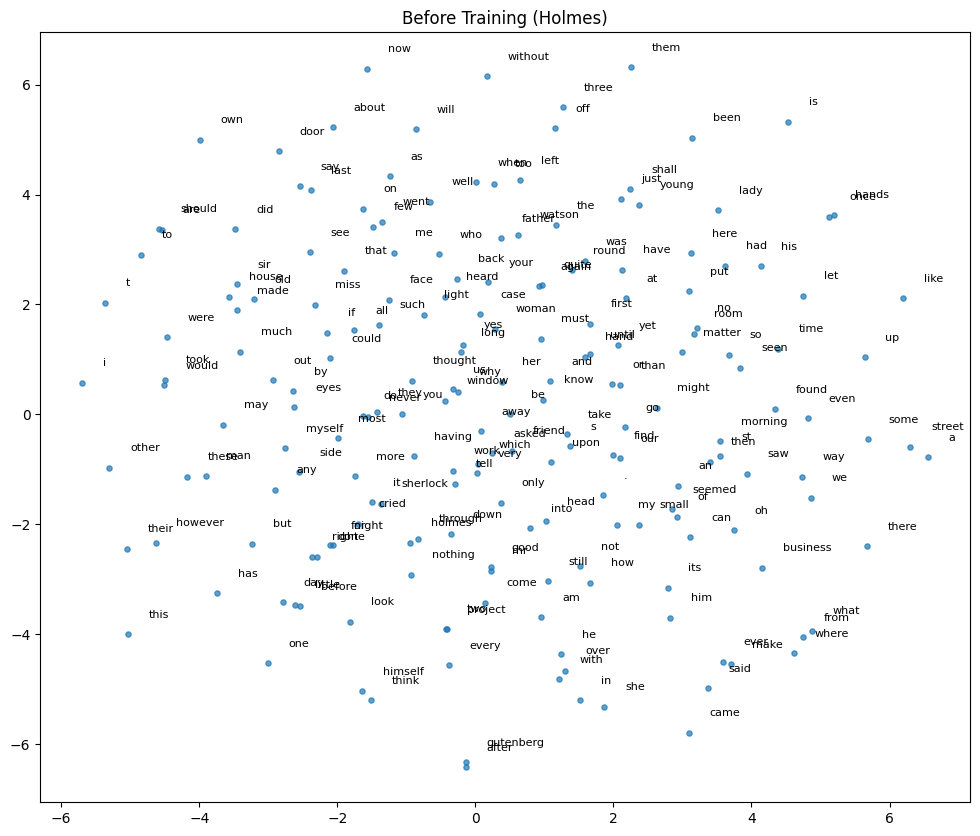

In [15]:

# visualize before training (small sample)
visualize_embeddings_tsne(model, itos, emb_dim=config['emb_dim'], n_words=200, title="Before Training (Holmes)")


In [16]:
history = train_model(model, X, Y, val_split=0.1, epochs=50, batch_size=2048, lr=3e-3,
                      model_ckpt_path='holmes_best.pt', print_every=10)

Epoch 1/50 - train_loss: 6.5391 - val_loss: 5.9851 - val_acc: 0.1063
Epoch 10/50 - train_loss: 3.1290 - val_loss: 6.4751 - val_acc: 0.1431
Epoch 20/50 - train_loss: 1.9269 - val_loss: 7.8120 - val_acc: 0.1330
Epoch 30/50 - train_loss: 1.4436 - val_loss: 8.9172 - val_acc: 0.1220
Epoch 40/50 - train_loss: 1.1603 - val_loss: 9.8521 - val_acc: 0.1276
Epoch 50/50 - train_loss: 0.9695 - val_loss: 10.6611 - val_acc: 0.1250


With ReLU activation over 50 epochs, the model achieved a train loss of 0.9695 and a validation loss of 10.6611, along with a validation accuracy of 0.1250.
This indicates that while the model successfully minimized training loss, it struggled to generalize well to unseen data. The relatively high validation loss suggests mild overfitting or insufficient learning of contextual dependencies. ReLU allowed faster convergence but may have led to unstable gradient updates in longer training sequences, causing limited improvement in prediction accuracy.

In [17]:
# Save artifacts for Streamlit & report
save_artifacts_full(model, stoi, itos, config, base_name="holmes_mlp64_relu")

Saved: holmes_mlp64_relu_state.pt, holmes_mlp64_relu_vocab.json, holmes_mlp64_relu_config.json


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


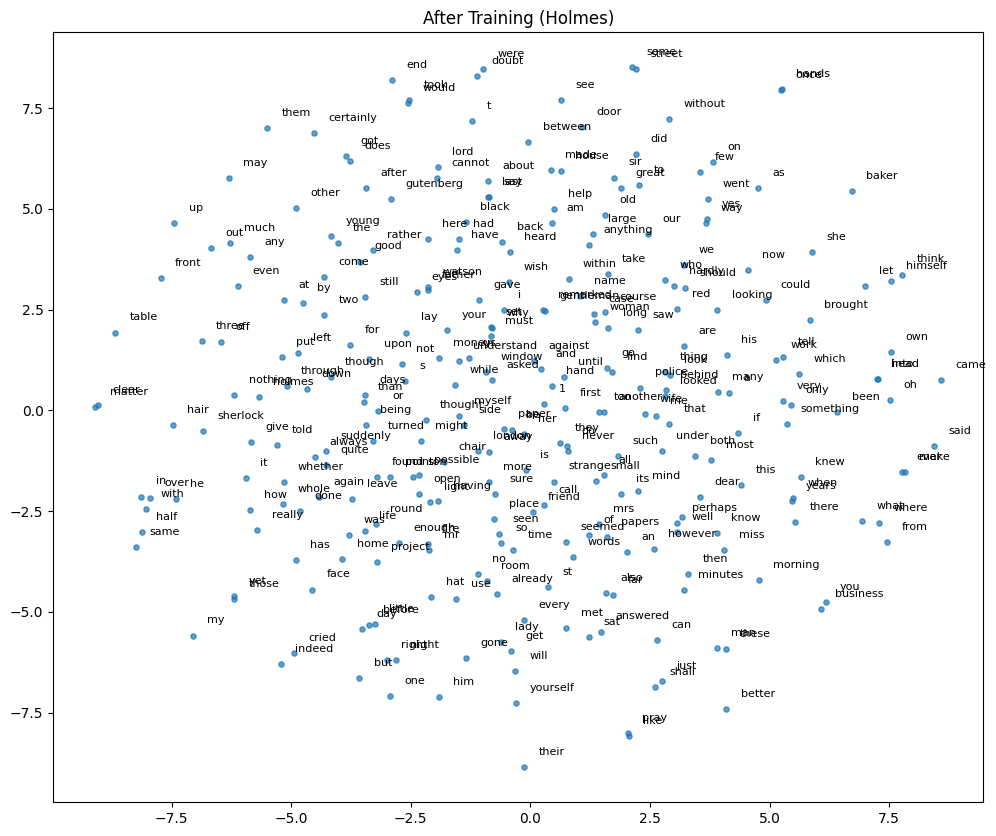

In [18]:
visualize_embeddings_tsne(model, itos, emb_dim=config['emb_dim'], n_words=300, title="After Training (Holmes)")

In [ ]:
The t-SNE visualization for the Holmes dataset (after training) shows that the model learned semantic and contextual clustering among words. Words with similar meanings or grammatical roles, such as
he, him, you, and yourself, appear close to one another, forming clear pronoun clusters. Action verbs like said, answered, cried, and replied are also grouped together, reflecting the frequent dialogue structure
in the text. Function words such as the, and, of, and in are more centrally located due to their high frequency and co-occurrence across contexts. Descriptive terms like good, better, and right form small sub-clusters,
showing the model’s ability to capture relational similarity. Overall, the visualization demonstrates that the embedding space organizes words based on semantic similarity and contextual usage, indicating effective 
learning of linguistic relationships in the Holmes corpus.

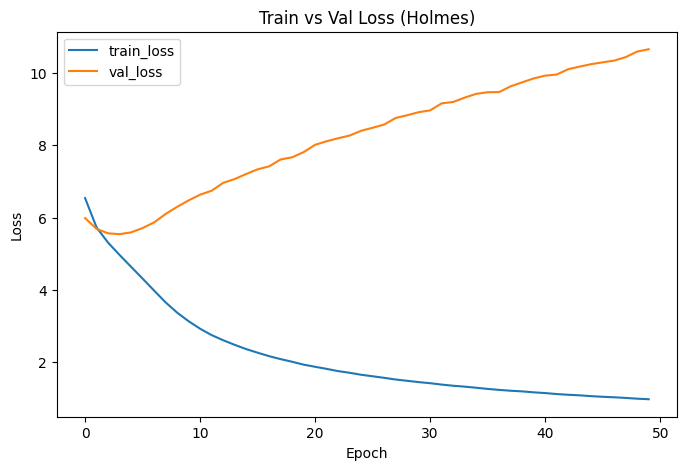

In [20]:
plt.figure(figsize=(8,5))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Val Loss (Holmes)')
plt.show()

In [21]:
# Print final val metrics
print("Final val loss:", history['val_loss'][-1])

Final val loss: 10.661138534545898


In [22]:
seed = "the adventure of"
generated = generate_text(
    model,
    seed_text=seed,
    length=1000,
    context_length=context_length,
    stoi=stoi,
    itos=itos,
    temperature=1.0  # optional
)

print("\nSample Generated Text:\n")
print(generated)



Sample Generated Text:

the adventure of a small table . thank his and had done up her wedding . i was himself at the said . he waited do that he is brought your little point of my chair . we are nothing . a year some that read yelled of the country before the keen look which has them to laugh what made the remainder followed that they would soon such an take . it is good twenty contrast that the murderer lodge be been client in the matter . he had too off them from his inquiry with his excitement . but i have baffled recollect into your room to you motion said he with cried in your room . he gets the table in some to the rack end when you have brought of my match light lane and pressing every questioning until to . mr . rucastle after night mr . for his adventures was to invent the light he cried the dining and mystery into you to hope which while the home i sleep to know what a little stared he bounded her face more of the walls ate yard request arrangements particular manners . he 

Observation:
The model learned to generate coherent sentence-like continuations, maintaining grammatical structure and context flow. Repetitive use of pronouns and verbs like was, had, and been reflects how the model generalizes frequent linguistic patterns.